In [114]:
import numpy as np
import pandas as pd
import yaml
import torch
from torch import nn
import scanpy as sc

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.vdm.denoising_model import SimpleMLPTimeStep
from celldreamer.models.vdm.vdm import VDM
from celldreamer.eval.optimal_transport import wasserstein

from celldreamer.models.base.utils import unsqueeze_right

device  = "cuda" if torch.cuda.is_available() else "cpu"

**Util function**

In [84]:
def init_feature_embeddings(dataset, dataset_config, device):
    feature_embeddings = {}  
    num_classes = {}
            
    for cov, cov_names in dataset.id2cov.items():
        feature_embeddings["y_"+cov] = CategoricalFeaturizer(len(cov_names), 
                                                                  dataset_config["one_hot_encode_features"], 
                                                                  device, 
                                                                  embedding_dimensions=dataset_config["cov_embedding_dimensions"])
        if dataset_config["one_hot_encode_features"]:
            num_classes["y_"+cov] = len(cov_names)
        else:
            num_classes["y_"+cov] = dataset_config["cov_embedding_dimensions"]
    return feature_embeddings

**Cofigurations**

In [85]:
ckpt = torch.load("/nfs/homedirs/pala/celldreamer/project_folder/celldreamer_search2/f88327f6-5ba3-4546-bedd-4dd480fd7823/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]

In [52]:
dataset_config = {'dataset_path': '../../datasets/processed/dentategyrus.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['clusters'],
                    'sampling_covariate': 'clusters',
                    'subsample_frac': 1,
                    'use_pca': False,
                    'encoder_type': 'proportions',
                    'target_max': 1,
                    'target_min': -1,
                    'n_dimensions': None,
                    'one_hot_encode_features': True,
                    'split_rates': [0.90, 0.05, 0.05],
                    'cov_embedding_dimensions': None}

generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'noise_schedule': 'fixed_linear',
                            'gamma_min': -3.,
                            'gamma_max': 3.,
                            'antithetic_time_sampling': True,
                            'scaling_method': 'log_normalization',
                            'x0_from_x_kwargs': {
                                'dims': [256, 256],
                                'batch_norm': True,
                                'dropout': False,
                                'dropout_p': 0.0
                            },
                            'pretrain_encoder': False,
                            'pretraining_encoder_epochs': 0,
                            'use_tanh_encoder': False}

**Initialization**

Initialize dataset 

In [53]:
data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                                layer_key=dataset_config["layer_key"],
                                covariate_keys=dataset_config["covariate_keys"],
                                subsample_frac=dataset_config["subsample_frac"], 
                                use_pca=dataset_config["use_pca"], 
                                encoder_type=dataset_config["encoder_type"],
                                target_max=dataset_config["target_max"], 
                                target_min=dataset_config["target_min"])

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}

/nfs/staff-ssd/pala/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


Initialize feature embeddings

In [54]:
feature_embeddings = init_feature_embeddings(dataset, dataset_config, device)

Initialize VDM 

In [55]:
generative_model = VDM(
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=in_dim,
            size_factor_statistics=size_factor_statistics,
            scaler=dataset.get_scaler(),
            encoder_type=dataset_config["encoder_type"],
            sampling_covariate=dataset_config["sampling_covariate"],
            model_type=denoising_model.model_type, 
            **generative_model_config  # model_kwargs should contain the rest of the arguments
        )

generative_model.load_state_dict(ckpt["state_dict"])

/nfs/staff-ssd/pala/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


<All keys matched successfully>

In [56]:
denoising_model

SimpleMLPTimeStep(
  (net): Sequential(
    (0): Linear(in_features=2002, out_features=64, bias=True)
    (1): SELU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): SELU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): SELU()
    (6): Linear(in_features=64, out_features=2000, bias=True)
  )
)

**Check the data**

In [57]:
adata_original = sc.read_h5ad(data_path)
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)

In [58]:
X = torch.tensor(adata_original.layers["X_counts"].todense())

In [59]:
# wasserstein(X_1, X_2)

More or less the range for the Wasserstein distance must be 100-200

**Collect checkpoints and run**

In [60]:
size_factor, z0_rescaled, X_generated = generative_model.sample(batch_size=1000, 
                                     n_sample_steps=1000, 
                                     clip_samples=True,
                                     covariate="clusters")

sampling: 100%|██████████| 1000/1000 [00:26<00:00, 37.88it/s]


Analyze the results

In [61]:
size_factor

tensor([[ 6563.9238],
        [ 1109.9653],
        [  299.3411],
        [ 2119.5244],
        [  900.2310],
        [ 1244.4460],
        [  874.4510],
        [  476.8022],
        [  900.6132],
        [  672.1928],
        [  439.4312],
        [ 1554.0237],
        [  680.8553],
        [  541.7771],
        [  308.0279],
        [  268.0278],
        [ 1065.4995],
        [ 1317.3008],
        [  869.1541],
        [  536.1453],
        [ 1033.5466],
        [ 1463.5775],
        [ 5613.5273],
        [ 1858.5363],
        [  647.8922],
        [  917.5182],
        [  502.8237],
        [  675.1655],
        [  950.7214],
        [  556.7641],
        [ 1374.2484],
        [ 1038.7365],
        [ 1309.2028],
        [  609.6585],
        [ 1023.5065],
        [  653.5721],
        [ 1149.4091],
        [  350.4579],
        [  852.7822],
        [  527.5189],
        [ 3631.8359],
        [  789.3029],
        [ 1383.2692],
        [ 3787.7544],
        [  564.8088],
        [ 

In [78]:
z0_rescaled.mean(1)

tensor([ 670.2957,  103.7467,   28.8087,  200.9136,   87.0942,  123.6050,
          86.4051,   44.3936,   87.1080,   63.8823,   42.3386,  161.5243,
          64.7279,   51.4255,   29.5634,   27.1748,  100.0920,  126.1440,
          78.4162,   51.9256,   97.3922,  140.8978,  534.4512,  180.9548,
          61.9592,   87.1010,   49.6291,   63.5717,   87.3125,   53.2174,
         128.4203,   99.9513,  131.7800,   60.5942,   89.3304,   61.4269,
         113.5146,   34.1609,   79.7918,   52.9583,  363.8786,   75.2004,
         128.8319,  367.1227,   53.7487,   35.6601,   51.3666,   77.0626,
          85.4557,  169.7371,   20.0183,   56.6627,   27.1662,   85.4369,
          33.3648,   69.2950,   48.7830,   95.2745,  129.5536,   80.7985,
          96.6269,   78.5065,   50.3957,   45.3696,   65.6171,   47.7463,
          89.0954,   56.9942,  157.9807,  103.7147,   57.6463,   42.0840,
         104.2421,   51.0865,   65.1986,   47.0644,   55.2179,   59.2640,
          73.5804,   48.2257,  357.375

In [72]:
for i in X_generated[0]:
    print(i)

tensor(6.1269)
tensor(5.8665)
tensor(0.)
tensor(7.4770)
tensor(0.)
tensor(6.3421)
tensor(5.1417)
tensor(7.7702)
tensor(0.)
tensor(4.6250)
tensor(0.)
tensor(6.3630)
tensor(0.)
tensor(4.5433)
tensor(0.)
tensor(4.9416)
tensor(0.)
tensor(7.8501)
tensor(6.5058)
tensor(2.3026)
tensor(0.)
tensor(7.7613)
tensor(5.2575)
tensor(3.7842)
tensor(5.0752)
tensor(7.2889)
tensor(7.7156)
tensor(7.6765)
tensor(2.8904)
tensor(6.2265)
tensor(4.8363)
tensor(7.7026)
tensor(7.7541)
tensor(4.8203)
tensor(7.5060)
tensor(0.)
tensor(7.6392)
tensor(7.5299)
tensor(6.6201)
tensor(0.)
tensor(0.)
tensor(7.6411)
tensor(4.3820)
tensor(0.)
tensor(4.8203)
tensor(0.)
tensor(5.2883)
tensor(5.3471)
tensor(0.)
tensor(0.)
tensor(4.3567)
tensor(7.5632)
tensor(4.3175)
tensor(7.0733)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(7.1381)
tensor(7.7293)
tensor(0.)
tensor(0.)
tensor(7.6401)
tensor(5.1417)
tensor(4.1589)
tensor(3.7136)
tensor(0.)
tensor(4.7449)
tensor(5.1705)
tensor(5.2883)
tensor(6.2186)
tensor(4.5218)
tensor(7.5235)
tens

Create adata and check plots

In [65]:
adata = sc.AnnData(X=X_generated.cpu().numpy())

In [66]:
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [67]:
adata.obs["size_factor"] = adata.X.sum(1)

/nfs/staff-ssd/pala/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


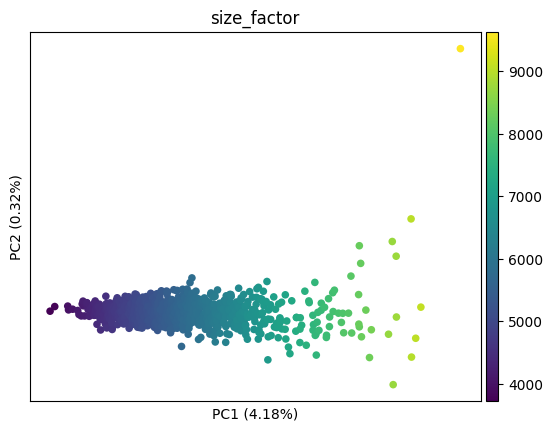

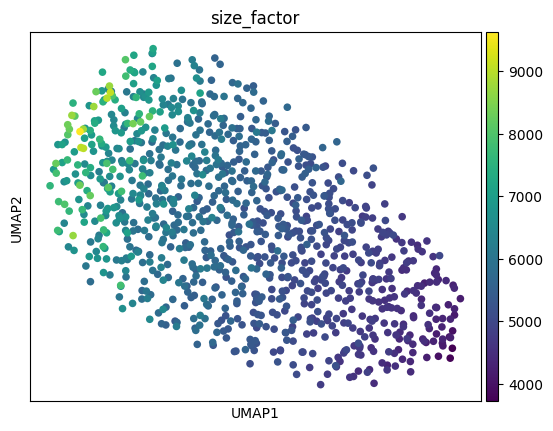

In [68]:
sc.pl.pca(adata, color="size_factor", annotate_var_explained=True)
sc.pl.umap(adata, color="size_factor")

/nfs/staff-ssd/pala/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


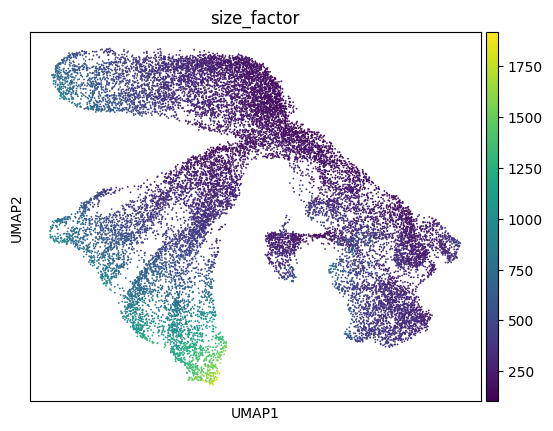

In [69]:
sc.pl.umap(adata_original, color="size_factor")

In [70]:
adata_original.layers["X_counts"].sum(1).ravel().mean()

1252.595

In [73]:
generative_model.denoising_model.model_type

'conditional_latent'

In [81]:
for i in generative_model.theta:
    print(i)

tensor(8.0122, grad_fn=<UnbindBackward0>)
tensor(8.0346, grad_fn=<UnbindBackward0>)
tensor(8.0829, grad_fn=<UnbindBackward0>)
tensor(8.0345, grad_fn=<UnbindBackward0>)
tensor(8.4253, grad_fn=<UnbindBackward0>)
tensor(8.3343, grad_fn=<UnbindBackward0>)
tensor(6.9349, grad_fn=<UnbindBackward0>)
tensor(8.1466, grad_fn=<UnbindBackward0>)
tensor(8.2508, grad_fn=<UnbindBackward0>)
tensor(8.1798, grad_fn=<UnbindBackward0>)
tensor(8.3662, grad_fn=<UnbindBackward0>)
tensor(8.0289, grad_fn=<UnbindBackward0>)
tensor(8.3268, grad_fn=<UnbindBackward0>)
tensor(8.0755, grad_fn=<UnbindBackward0>)
tensor(8.0831, grad_fn=<UnbindBackward0>)
tensor(8.7753, grad_fn=<UnbindBackward0>)
tensor(8.5755, grad_fn=<UnbindBackward0>)
tensor(8.2205, grad_fn=<UnbindBackward0>)
tensor(8.0121, grad_fn=<UnbindBackward0>)
tensor(8.2139, grad_fn=<UnbindBackward0>)
tensor(8.7378, grad_fn=<UnbindBackward0>)
tensor(8.1202, grad_fn=<UnbindBackward0>)
tensor(8.2432, grad_fn=<UnbindBackward0>)
tensor(8.5544, grad_fn=<UnbindBack

**Try new resnet**

In [118]:
class MLPTimeStep(nn.Module):
    def __init__(self, 
                 in_dim: int,
                 hidden_dim: int,
                 dropout_prob: int,
                 n_blocks: int, 
                 model_type: str,
                 gamma_min: float, 
                 gamma_max: float,
                 time_varying=False):
        
        super().__init__()
        
        # Gene expression dimension 
        self.in_dim = in_dim
        
        # The network downsizes the input multiple times 
        self.hidden_dim = hidden_dim * (2**n_blocks)
        
        # Initialize the gammas
        self.gamma_min = gamma_min
        self.gamma_max = gamma_max
        self.model_type = model_type
        self.time_varying = time_varying
        added_dimensions = (1 if time_varying else 0) + (1 if self.model_type=="conditional_latent" else 0)
        
        # Initial convolution
        self.net_in = nn.Linear(in_dim, self.hidden_dim)

        # Down path: n_blocks blocks with a resnet block and maybe attention.
        self.down_blocks = []
        self.up_blocks = []
        for _ in range(n_blocks):
            self.down_blocks.append(ResnetBlock(in_dim=self.hidden_dim,
                                                     out_dim=self.hidden_dim // 2,
                                                     added_dimensions=added_dimensions,
                                                     dropout_prob=dropout_prob,
                                                     time_varying=time_varying,
                                                     model_type=model_type))

            self.up_blocks.insert(-1, ResnetBlock(in_dim=self.hidden_dim // 2,
                                                        out_dim=self.hidden_dim,
                                                        added_dimensions=added_dimensions,
                                                        dropout_prob=dropout_prob,
                                                        time_varying=time_varying,
                                                        model_type=model_type))
            self.hidden_dim = self.hidden_dim // 2
        
        self.down_blocks = nn.ModuleList(self.down_blocks)
        self.up_blocks = nn.ModuleList(self.up_blocks)

        self.net_out = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_dim * (2**n_blocks), in_dim))

    def forward(self, x, g_t, l):
        if self.time_varying:
            if g_t.shape[0] == 1:
                g_t = g_t.repeat((x.shape[0],) + (1,) * (g_t.ndim-1))
            if g_t.ndim != x.ndim:
                g_t = unsqueeze_right(g_t, x.ndim-g_t.ndim)
        
        if self.model_type=="conditional_latent":
            if l.ndim != x.ndim:
                l = unsqueeze_right(l, x.ndim-l.ndim)  
                
        # Get gamma to shape (B, ).
        t = (g_t - self.gamma_min) / (self.gamma_max - self.gamma_min)

        h = self.net_in(x)  # (B, embedding_dim, H, W)
        for down_block in self.down_blocks:  # n_blocks times
            h = down_block(h, t, l)
        for up_block in self.up_blocks:  
            h = up_block(h, t, l)
            
        pred = self.net_out(h)
        return pred + x

class ResnetBlock(nn.Module):
    """
    A block for a Multi-Layer Perceptron (MLP) with skip connection.

    Args:
        input_dim (int): Dimension of the input features.
        output_dim (int, optional): Dimension of the output features. Defaults to None, in which case it's set equal to input_dim.
        condition_dim (int, optional): Dimension of the conditional input. Defaults to None.
        dropout_prob (float, optional): Dropout probability. Defaults to 0.0.
        norm_groups (int, optional): Number of groups for layer normalization. Defaults to 32.
    """
    def __init__(
        self,
        in_dim,
        out_dim=None,
        added_dimensions=0,
        dropout_prob=0.0,
        time_varying=True,
        model_type="conditional_latent"):
        
        super().__init__()
        
        self.time_varying = time_varying
        self.model_type = model_type

        # Set output_dim to input_dim if not provided
        out_dim = in_dim if out_dim is None else out_dim

        self.out_dim = out_dim

        # First linear block with LayerNorm and SiLU activation
        self.net1 = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.SiLU(),
            nn.Linear(out_dim, out_dim))

        # Second linear block with LayerNorm, SiLU activation, and optional dropout
        self.net2 = nn.Sequential(
            nn.SiLU(),
            *([nn.Dropout(dropout_prob)] * (dropout_prob > 0.0)),
            nn.Linear(out_dim+2, out_dim),
        )

        # Linear projection for skip connection if input_dim and output_dim differ
        if in_dim != out_dim:
            self.skip_proj = nn.Linear(in_dim, out_dim)

    def forward(self, x, t, l=None):
        """
        Forward pass of the MLP block.

        Args:
            x (torch.Tensor): Input features.
            condition (torch.Tensor, optional): Conditional input. Defaults to None.

        Returns:
            torch.Tensor: Output features.
        """
        # Forward pass through the first linear block
        h = self.net1(x)

        # Add conditional input if provided
        if self.time_varying:
            h = torch.cat([h, t], dim=1)
        if self.model_type=="conditional_latent":
            h = torch.cat([h, l], dim=1)

        # Forward pass through the second linear block
        h = self.net2(h)

        # Linear projection for skip connection if input_dim and output_dim differ
        if x.shape[1] != self.out_dim:
            x = self.skip_proj(x)

        # Add skip connection to the output
        assert x.shape == h.shape
        return x + h

    def _zero_init(self, module):
        nn.init.constant_(module.weight.data, 0)
        if hasattr(module, 'bias') and module.bias is not None:
            nn.init.constant_(module.bias.data, 0)
        return module

In [119]:
mlp = MLPTimeStep(in_dim=2000,
                 hidden_dim=128,
                 dropout_prob=0.0,
                 n_blocks=2, 
                 model_type="conditional_latent",
                 gamma_min=-5.0, 
                 gamma_max=5.0,
                 time_varying=True)

In [120]:
gexp = torch.randn(16, 2000)
g_t = torch.randn(16)
l = torch.randn(16)

In [122]:
mlp(gexp, g_t, l).shape

torch.Size([16, 2000])

In [116]:
mlp

MLPTimeStep(
  (net_in): Linear(in_features=2000, out_features=512, bias=True)
  (down_blocks): ModuleList(
    (0): ResnetBlock(
      (net1): Sequential(
        (0): Linear(in_features=514, out_features=256, bias=True)
        (1): SiLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
      )
      (net2): Sequential(
        (0): SiLU()
        (1): Linear(in_features=256, out_features=256, bias=True)
      )
      (skip_proj): Linear(in_features=514, out_features=256, bias=True)
    )
    (1): ResnetBlock(
      (net1): Sequential(
        (0): Linear(in_features=258, out_features=128, bias=True)
        (1): SiLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
      )
      (net2): Sequential(
        (0): SiLU()
        (1): Linear(in_features=128, out_features=128, bias=True)
      )
      (skip_proj): Linear(in_features=258, out_features=128, bias=True)
    )
  )
  (up_blocks): ModuleList(
    (0): ResnetBlock(
      (net1): Sequential(
 